In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as slinalg
%matplotlib inline

import sys
sys.path.append('../../module')
import gym2
import util as U

In [28]:
env = gym2.make('Linear-v1')
Q = .01 * np.eye(2)
R = .01 * np.eye(1)
lam = .5

In [63]:
def array_exp(A):
    v, p = np.linalg.eig(A)
    align = np.array([[v[0], 0],[0, v[1]]])
    exp = np.exp(align)
    exp[~np.eye(exp.shape[0],dtype=bool)] = 0
    out = np.dot(np.dot(p, exp), np.linalg.inv(p))
    return out


def next_state(state, action, tau, env):
    # mean of next state when const action and tau is input
    A = env.A
    B = env.B
    eAt = array_exp(A*tau)
    A_inv = np.linalg.inv(A)
    
    integral = np.dot(np.dot(eAt, A_inv), B) \
             - np.dot(np.dot(eAt, A_inv), np.dot(array_exp(-A*tau), B))
    s_prime = np.dot(eAt, state) + integral *action 
    
    return s_prime


def variance(A, D, tau):
    tmp = np.dot(array_exp(A*tau), D)
    Q = np.dot(D.reshape(2,1), D.reshape(1,2)) - np.dot(tmp, tmp)
    V = slinalg.solve_lyapunov(A, -Q)
    return V
    
    
def control_law(state, env, Q=Q, R=R, l=lam):
    A = env.A
    B = env.B
    D = env.D
    next_value_weight = 100
    
    taus = np.linspace(.01, 10., 1000)
    evaluation = np.inf
    
    # riccati
    P = slinalg.solve_continuous_are(A, B.reshape(B.shape[0],1), Q, R)
    A_inv = np.linalg.inv(A)
    
    for tau in taus:
        # calculate optimal action with fixed `tau`
        eAt = array_exp(A*tau)
        
        # ∂s'/∂u
        dsdu = np.dot(np.dot(eAt, A_inv), B) \
             - np.dot(np.dot(eAt, A_inv), np.dot(array_exp(-A*tau), B))
        # int exp(A(t-τ))Budt
        integral = dsdu

        # ∂c/∂u = first + second * u, c: instant cost
        first = 2 * np.dot(np.dot(dsdu, P), np.dot(eAt, state))
        first *= next_value_weight
        second = 2 * np.dot(np.dot(dsdu, P), integral)
        second = next_value_weight * second + 2

        # optimal action
        u = - first / second
        
        # evaluation
        s_prime = next_state(state, u, tau, env)
        V_lqr = np.dot(np.dot(s_prime, P), s_prime) + np.trace(np.dot(P, variance(A, D, tau)))
        ev = u**2 - l * tau + next_value_weight * V_lqr
        print(s_prime, ev, [u, tau])
        if ev < evaluation:
            control = np.array([u, tau])
            evaluation = ev
    
    return control

In [64]:
state = np.array([3.,3.])
control_law(state, env)

[3.08776471 2.96902027] 6.21747349467551 [-0.058307779304959895, 0.01]
[3.17090151 2.93593854] 6.358530930366954 [-0.11853996300551478, 0.02]
[3.24917624 2.90056144] 6.494766722321796 [-0.18053975006548464, 0.03]
[3.32236151 2.86272541] 6.625418801565802 [-0.2441255645625698, 0.04]
[3.39024192 2.82229948] 6.749754479526396 [-0.3090928681630225, 0.05]
[3.45261931 2.77918742] 6.8670801197347595 [-0.375216473153303, 0.060000000000000005]
[3.50931777 2.73332941] 6.9767506971511155 [-0.4422533279622921, 0.06999999999999999]
[3.56018824 2.68470286] 7.078178932315716 [-0.5099457262244608, 0.08]
[3.60511265 2.63332259] 7.170843690654054 [-0.5780248706386741, 0.09]
[3.64400731 2.57924024] 7.254297355738919 [-0.6462147054884556, 0.09999999999999999]
[3.67682563 2.52254295] 7.328171918791748 [-0.7142359179255809, 0.11]
[3.70355995 2.46335128] 7.392183573699851 [-0.7818099989801867, 0.12]
[3.72424244 2.40181657] 7.44613566477233 [-0.8486632514301806, 0.13]
[3.73894519 2.33811765] 7.489919899921661

[ 0.64918697 -0.46114972] 3.9779533865389016 [-1.3128793317456378, 1.4100000000000001]
[ 0.64386997 -0.46162828] 4.021572435273505 [-1.3090816574376847, 1.42]
[ 0.63865342 -0.46208294] 4.066601102950948 [-1.3053360910310556, 1.43]
[ 0.63353496 -0.46251468] 4.113059110927519 [-1.301641842225337, 1.44]
[ 0.62851224 -0.46292441] 4.160966804153952 [-1.2979981313590845, 1.45]
[ 0.62358303 -0.46331304] 4.210345156916624 [-1.2944041894772582, 1.46]
[ 0.61874512 -0.46368141] 4.261215778931999 [-1.2908592583792495, 1.47]
[ 0.61399638 -0.46403034] 4.313600921773213 [-1.287362590643116, 1.48]
[ 0.60933475 -0.46436062] 4.367523485660547 [-1.2839134496374003, 1.49]
[ 0.60475821 -0.464673  ] 4.423007026586692 [-1.2805111095145072, 1.5]
[ 0.60026481 -0.46496819] 4.480075763777759 [-1.27715485518486, 1.51]
[ 0.59585265 -0.46524689] 4.538754587522001 [-1.2738439822876604, 1.52]
[ 0.59151988 -0.46550976] 4.599069067326015 [-1.2705777971416456, 1.53]
[ 0.5872647  -0.46575745] 4.6610454604223985 [-1.26735

[ 0.35273339 -0.46113489] 52.36061784011132 [-1.0625049457757791, 2.8499999999999996]
[ 0.35208993 -0.46106434] 53.418787225681044 [-1.0618510302883972, 2.86]
[ 0.35145413 -0.46099425] 54.49848003810813 [-1.0612042779437567, 2.8699999999999997]
[ 0.35082589 -0.46092462] 55.600130516439336 [-1.060564603665428, 2.88]
[ 0.35020511 -0.46085547] 56.724181680612894 [-1.059931923316414, 2.8899999999999997]
[ 0.34959168 -0.46078678] 57.87108550634034 [-1.0593061541775952, 2.9]
[ 0.34898551 -0.46071855] 59.04130311051253 [-1.0586872154575135, 2.9099999999999997]
[ 0.3483865  -0.46065079] 60.235304929687956 [-1.0580750255317763, 2.92]
[ 0.34779455 -0.4605835 ] 61.45357091291024 [-1.0574695056132297, 2.9299999999999997]
[ 0.34720957 -0.46051668] 62.69659071168908 [-1.0568705770591718, 2.94]
[ 0.34663146 -0.46045033] 63.96486387651861 [-1.0562781625171263, 2.9499999999999997]
[ 0.34606014 -0.46038444] 65.25890005731392 [-1.0556921863517628, 2.96]
[ 0.34549552 -0.46031904] 66.5792192073705 [-1.0551

[ 0.30770506 -0.45521632] 831.5212389916844 [-1.0151302324731264, 4.2299999999999995]
[ 0.3075653  -0.45519472] 848.3366150076426 [-1.0149777712867938, 4.24]
[ 0.30742697 -0.45517327] 865.491794668734 [-1.014826753277662, 4.25]
[ 0.30729781 -0.4551639 ] 882.9936449029008 [-1.014677693061411, 4.26]
[ 0.30717004 -0.45515468] 900.8491662266059 [-1.0145300397293577, 4.27]
[ 0.30702067 -0.4551103 ] 919.0654977027759 [-1.0143832088495417, 4.28]
[ 0.30689573 -0.45510152] 937.6499398477234 [-1.0142386606434817, 4.29]
[ 0.30676439 -0.45508097] 956.6099201174384 [-1.0140949695415005, 4.3]
[ 0.30662696 -0.45504915] 975.9530270796354 [-1.0139531927242826, 4.31]
[ 0.30649098 -0.45501766] 995.687001449598 [-1.0138131712781169, 4.32]
[ 0.30637121 -0.45500927] 1015.8197393129988 [-1.0136735912666532, 4.33]
[ 0.30623776 -0.45497797] 1036.3592936599482 [-1.0135359986218715, 4.34]
[ 0.3061589  -0.45502879] 1057.31389542675 [-1.0134003401984684, 4.35]
[ 0.30600524 -0.4549628 ] 1078.6919020651892 [-1.01326

[ 0.27880133 -0.42513335] 14249.615208213652 [-1.003616023757975, 5.6499999999999995]
[ 0.24800383 -0.37774668] 14537.503959391579 [-1.00349719504996, 5.66]
[ 0.27873803 -0.4251246 ] 14831.219140983187 [-1.0035442054152193, 5.67]
[ 0.30944258 -0.47245528] 15130.86813247774 [-1.003482506682579, 5.68]
[ 0.30944363 -0.4724995 ] 15436.565031201873 [-1.0035541065735112, 5.6899999999999995]
[ 0.30941165 -0.47249332] 15748.437293678757 [-1.0035186358514456, 5.7]
[ 0.34025749 -0.52003538] 16066.616975604107 [-1.0038750964231542, 5.71]
[ 0.30934866 -0.47248114] 16391.21011647109 [-1.0034487560084535, 5.72]
[ 0.30925425 -0.47237916] 16722.36737645355 [-1.0032100511888071, 5.7299999999999995]
[ 0.30916147 -0.47227918] 17060.21457726745 [-1.002975864369704, 5.74]
[ 0.37079239 -0.5672271 ] 17404.90154268701 [-1.0034977343395124, 5.75]
[ 0.30934946 -0.47264389] 17756.52456938073 [-1.0037098033319904, 5.76]
[ 0.37079974 -0.5673186 ] 18115.27685023859 [-1.0036246305375827, 5.77]
[ 0.3090467  -0.472263

[-113.25586726  179.08668993] 229384.12861150937 [-0.9207602482978565, 7.03]
[-142.14729498  226.23870585] 236426.44216456838 [-1.1613763802473096, 7.04]
[ 102.03542194 -153.83005864] 237541.09405357565 [-0.8001866000217781, 7.05]
[0.00051636 0.00025818] 239092.4079281238 [-0.9999998891399514, 7.06]
[0.00064371 0.00032185] 243922.70173335462 [-1.1221200010782206, 7.07]
[ 183.28674319 -272.03951205] 258892.33036511924 [-1.420636264252441, 7.08]
[-141.24032208  224.38261568] 260481.87222687592 [-1.1523545965674034, 7.09]
[1.85886588e-04 9.29432940e-05] 259005.28512195224 [-0.6121147384895428, 7.1]
[0.00078528 0.00039264] 264238.8236924959 [-1.2644223028956376, 7.11]
[-178.62519933  285.83480795] 280259.878709792 [-0.7327097804873958, 7.12]
[ 309.38250417 -449.43601294] 302774.7042114924 [-1.1799360644972947, 7.13]
[-210.12297329  338.28534977] 295504.8819138292 [-0.865911789881478, 7.14]
[ 307.99208448 -448.0230886 ] 313801.90747464576 [-1.1758186149187153, 7.15]
[0.00072808 0.00036404] 

[1.14069484e-04 5.70347420e-05] 4899362.287048338 [-0.999999994589894, 8.57]
[2.94676283e-09 1.47338142e-09] 4998335.033422583 [0.005103374892971561, 8.58]
[3.27418093e-10 1.63709046e-10] 5099308.182152416 [0.0017124247341408214, 8.59]
[2.99769454e-09 1.49884727e-09] 5202321.123942073 [0.0052070067208862605, 8.6]
[2.96859071e-09 1.48429535e-09] 5307415.065272261 [-0.005204862127148206, 8.61]
[1.08506250e-04 5.42531252e-05] 5414633.04512002 [-0.9999999951047335, 8.62]
[7.60337571e-10 3.80168785e-10] 5524014.951769913 [-0.002661790848322485, 8.63]
[1.92812877e-10 9.64064384e-11] 5635607.53979882 [0.0013496780394434311, 8.64]
[1.05299401e-04 5.26497006e-05] 5749455.447747435 [-0.9999999953898118, 8.65]
[1.04251663e-04 5.21258316e-05] 5865602.215897424 [-0.9999999954810993, 8.66]
[ 2725.52406155 -3774.22150954] 8003371.252249035 [-0.0012247523165494513, 8.67]
[1.02187336e-04 5.10936679e-05] 6104982.11238698 [-0.9999999956582882, 8.68]
[1.01170557e-04 5.05852786e-05] 6228310.995880911 [-0.9

array([-1.49161958,  1.05      ])

In [57]:
l = .5
env.reset()
initial_state = np.array([3., 3.])
env.set_state(initial_state)

states = [initial_state]
detail_states = [initial_state]

time_limit = 10
time_log = [0.]
taus = []
acc_time = 0
episode_reward = 0
i = 0
detail_time_log = [0.]

action_log = []


while True:
    reward = 0
    x = env.state
    a_agent, tau = control_law(x, env)
    taus.append(tau)
    acc_time += tau
    time_log.append(acc_time)
    dt = 0.01
    action_repetition = int(tau * 100)  # minimum natural number which makes `dt` smaller than 0.005
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        action_log.append(a_agent)
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau)
        reward += r
        detail_states.append(env.state)
        i += 1
        detail_time_log.append(i * dt)
    print(env.state, tau)
    reward *= dt
    reward += - 0.01 * a_agent**2 + l * tau
    episode_reward += reward
    states.append(env.state)
    if acc_time > time_limit:
        break
action_log.append(control_law(env.state, env)[0])
states = np.array(states)
detail_states = np.array(detail_states)

[-1.74756887 -1.74791853] 1.05
[-1.31212059  0.02637658] 0.8300000000000001
[-2.04602508 -0.84744853] 0.5
[-0.99152973 -0.05431243] 0.76
[-0.11011013  0.17839923] 0.43
[-0.13270111  0.03120755] 0.18000000000000002
[-0.44922028 -0.26597512] 0.18000000000000002
[-0.63923489 -0.45070814] 0.01
[-0.67566285 -0.4745508 ] 0.01
[-0.74255202 -0.52826672] 0.01
[-0.79490562 -0.17933372] 0.47000000000000003
[-1.44382399 -0.63989205] 0.4
[-0.07411957  0.35710211] 0.64
[0.54619975 0.54864195] 0.18000000000000002
[0.64714485 0.62735533] 0.01
[0.77730992 0.73277206] 0.01
[0.90923979 0.17335982] 0.53
[1.26816033 0.53499403] 0.44
[1.03988347 0.21006494] 0.59
[ 0.47526567 -0.03572149] 0.48000000000000004
[-0.10205581 -0.34643335] 0.23
[-0.19939276 -0.201874  ] 0.15000000000000002
[-0.13320234 -0.06949343] 0.17
[0.24107391 0.27891227] 0.18000000000000002
[0.63038514 0.46018195] 0.15000000000000002
[0.73458239 0.55086519] 0.01
[-0.65877865 -0.68159934] 0.48000000000000004
[-0.65533667 -0.64994837] 0.01
[-0

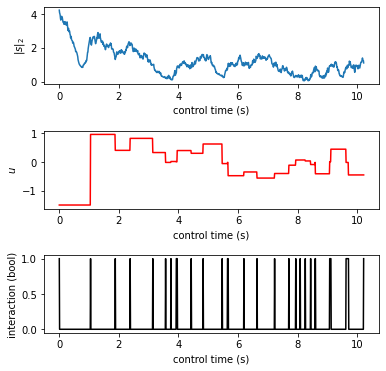

In [58]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.6)

# state
plt.subplot(3,1,1)
plt.xlabel('control time (s)')
plt.ylabel('$\|s\|_2$')
plt.plot(detail_time_log, np.linalg.norm(detail_states, axis=1))
#plt.scatter(time_log, states[:,0], marker='.')

# action
plt.subplot(3,1,2)
plt.xlabel('control time (s)')
plt.ylabel('$u$')
plt.plot(detail_time_log, action_log, color='red')

# communication
indices = []
for t in np.round(time_log, decimals=2):
    if t in np.round(detail_time_log, decimals=2):
        indices.append(np.where(t == np.round(detail_time_log, decimals=2))[0][0])
com = np.zeros_like(detail_time_log)
com[indices] = 1
plt.subplot(3,1,3)
plt.xlabel('control time (s)')
plt.ylabel('interaction (bool)')
plt.plot(detail_time_log, com, color='black')

plt.show()

In [65]:
import warnings
warnings.filterwarnings('ignore')
from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(16, activation="relu")(x)
    x1 = Dense(16, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(16, activation="relu")(x)
    x2 = Dense(16, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

In [66]:
NN = branch_actor((2,),(2,))
NN.compile(loss='mse', optimizer='adam')

In [61]:
# make train data
s1 = np.linspace(-7,7,100)
s2 = np.linspace(-7,7,100)
S1, S2 = np.meshgrid(s1, s2)
batch = []

for state in zip(S1.flatten(), S2.flatten()):
    state = np.array(state)
    action = control_law(state, env)
    batch.append([state, action])
    
batch = np.array(batch)

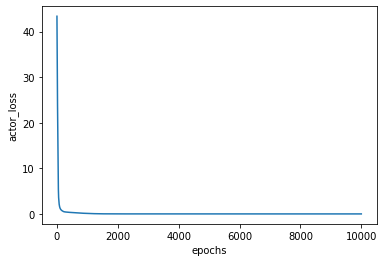

In [67]:
batch_size = 64

epochs = 10000
losses = []
for _ in range(epochs):
    indices = np.random.choice(range(10000),batch_size,replace=False)
    states = batch[:,0].reshape(10000,1,2)
    actions = batch[:,1]
    
    
    loss = NN.train_on_batch(states, actions)
    losses.append(loss)
    
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('actor_loss')
plt.show()


In [68]:
NN.save_weights('./saved_agent/mb_self_extend.h5')